### Imports

In [64]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import feature_selection
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from IPython.core.pylabtools import figsize 
%matplotlib inline

### Aux Functions

### Analysis

In [44]:
varq = pd.read_csv("../data/processed/properties-varq.tab.gz", sep="\t", index_col="MUTANT")

In [45]:
varq.columns

Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', '3DID', 'PDB', 'ACTIVE_SITE', 'VARIATION_ENERGY',
       'TYPE'],
      dtype='object')

In [46]:
varq.AGGREGABILITY.shape

(17869,)

In [47]:
varq.AGGREGABILITY.isnull().sum()

5570

In [48]:
varq.VARIATION_ENERGY.isnull().sum()

0

In [51]:
varq.index.unique().shape

(17869,)

In [52]:
print("Size: \n", varq.shape)
print("\nValue counts of TYPE: \n", varq.TYPE.value_counts())

Size: 
 (17869, 11)

Value counts of TYPE: 
 Benign        11763
Pathogenic     6106
Name: TYPE, dtype: int64


In [53]:
varq[["PDB","ACTIVE_SITE","3DID","TYPE"]].describe()

,PDB,ACTIVE_SITE,3DID,TYPE
count,17869,981,17869,17869
unique,2,1,2,2
top,False,BINDING,False,Benign
freq,15502,981,14431,11763


In [54]:
varq.describe()

,SASA,SASA_PERCENTAGE,BFACTOR,SWITCHBILITY,AGGREGABILITY,CONSERVATION,VARIATION_ENERGY
count,16798.000000,16798.000000,16798.000000,15651.000000,12299.000000,6099.000000,17869.000000
mean,36.869348,0.172637,54.651370,0.403744,4.983431,0.353983,2.250763
std,40.633632,0.181814,65.762465,0.935355,17.533670,0.359287,4.056646
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.130000,-13.530900
25%,2.187000,0.010000,19.905625,0.000000,0.000000,0.250000,0.133057
50%,22.220000,0.110000,37.853750,0.008850,0.000000,0.300000,1.134230
75%,60.210250,0.300000,62.090000,0.303500,0.131000,0.370000,3.056210
max,254.526000,0.750000,755.610000,9.720000,100.000000,11.700000,57.513400


In [56]:
corr = varq.drop(['3DID', 'PDB'], axis=1).corr()

In [57]:
corr

,SASA,SASA_PERCENTAGE,BFACTOR,SWITCHBILITY,AGGREGABILITY,CONSERVATION,VARIATION_ENERGY
SASA,1.000000,0.962449,0.060265,-0.042781,-0.017759,0.008619,-0.306423
SASA_PERCENTAGE,0.962449,1.000000,0.091254,-0.050652,-0.014159,0.015112,-0.329032
BFACTOR,0.060265,0.091254,1.000000,0.051770,0.106277,-0.030563,-0.067454
SWITCHBILITY,-0.042781,-0.050652,0.051770,1.000000,0.047975,-0.002319,-0.014635
AGGREGABILITY,-0.017759,-0.014159,0.106277,0.047975,1.000000,0.001127,-0.003761
CONSERVATION,0.008619,0.015112,-0.030563,-0.002319,0.001127,1.000000,0.027866
VARIATION_ENERGY,-0.306423,-0.329032,-0.067454,-0.014635,-0.003761,0.027866,1.000000


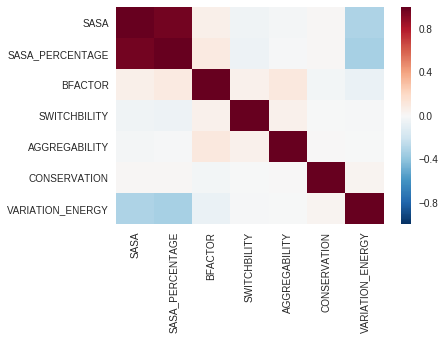

In [58]:
plot = sns.heatmap(corr)
figure = plot.get_figure()

### Machine Learning

In [59]:
model_dict = {
    'lr':{'pipe':('lr', LogisticRegression()),
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'LogisticRegression'
       },
    'rf':{'pipe':('rf', RandomForestClassifier(random_state = 100)),
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2]}],
        'name':'Random Forest'
       },
}

In [94]:
le = LabelEncoder()

X = varq[~varq.TYPE.isnull()].drop(['3DID', 'PDB', 'TYPE'], 1).replace({"ACTIVE_SITE": {"BINDING": 1, np.nan: 0}})
y = le.fit_transform(varq[~varq.TYPE.isnull()].TYPE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

#### Random Forest

In [95]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
algorithm = 'rf'
model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")),
                  model_dict[algorithm]['pipe']])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [174]:
X_test.shape

(5897, 8)

In [175]:
pd.Series(y_test).value_counts()

0    3882
1    2015
dtype: int64

In [96]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:   16.4s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7ffb181ca3b8>,
       error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_spl...imators=10, n_jobs=1, oob_score=False, random_state=100,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': [4, 'sqrt', 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [97]:
rf = gs.best_estimator_

In [98]:
gs.best_score_

0.67934071947456032

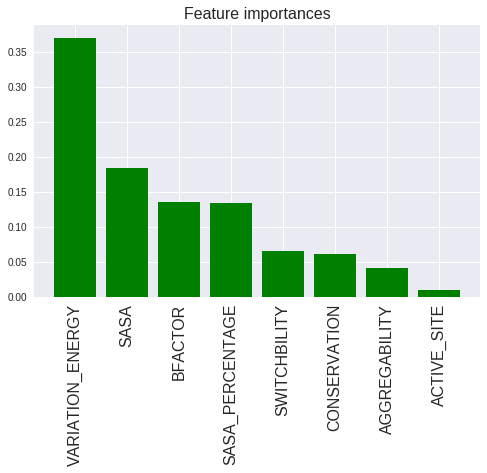

In [99]:
importances = [(x_train.columns[e], x) for e, x in enumerate(rf.steps[1][1].feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
figsize(8,5)
plt.title("Feature importances", fontsize=16)
plt.bar(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
plt.xticks(range(len(importances)), [x for x, y in importances], rotation='vertical', fontsize=16)
# plt.xlim([0, range(len(importances))])
plt.show()

In [178]:
print(classification_report(y_test, rf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.70      0.92      0.80      3882
          1       0.62      0.25      0.36      2015

avg / total       0.67      0.69      0.65      5897



In [133]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [134]:
fpr.shape

(2394,)

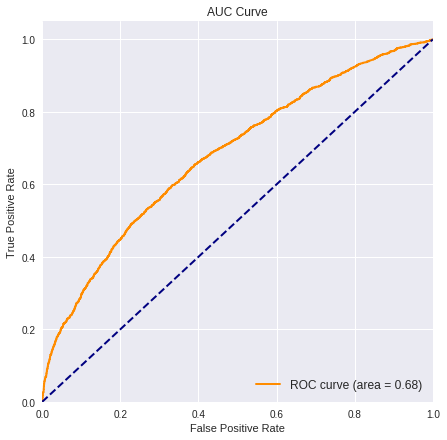

In [145]:
figsize(7,7)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 12})
plt.show()

#### Logistic Regression

In [185]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
algorithm = 'lr'
model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")),
                  model_dict[algorithm]['pipe']])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [186]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=2)]: Done  42 out of  42 | elapsed:    2.0s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7ffb03fec200>,
       error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid=[{'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'lr__class_weight': [None, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [187]:
lr = gs.best_estimator_

In [182]:
gs.best_score_

0.649536589223908

In [183]:
importances = list(zip(X_train.columns.tolist(), lr.steps[1][1].coef_[0].tolist()))

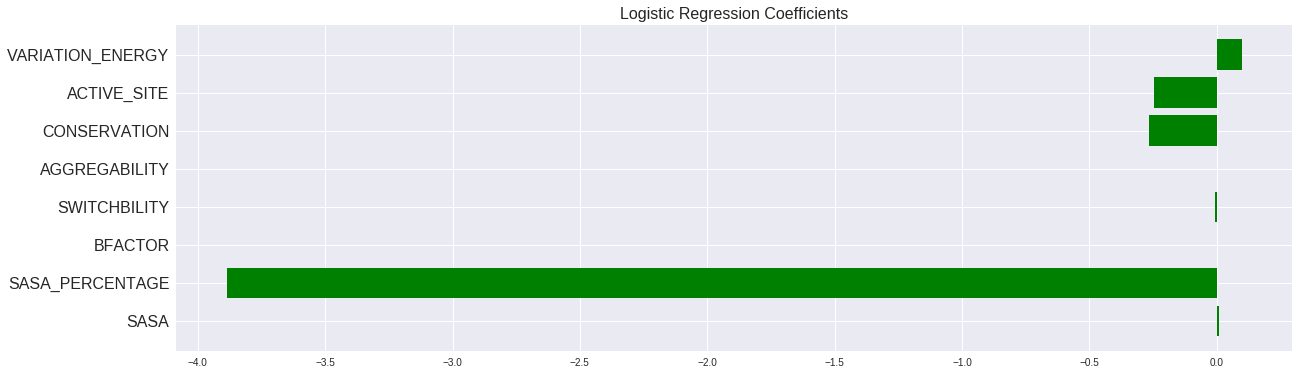

In [184]:
figsize(20,6)
plt.title("Logistic Regression Coefficients", fontsize=16)
plt.barh(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
# plt.xticks(np.arange(-1.1,.7,.05))
plt.show()